# Punto 4 Segmentación de Imágenes Médicas 

### ETL y EDA

## Files and Field Descriptions

{train|test}/ Folders containing TIFF images of the tiles. Each tile is 512x512 in size.

polygons.jsonl Polygonal segmentation masks in JSONL format, available for Dataset 1 and Dataset 2. Each line gives JSON annotations for a single image with:
- id Identifies the corresponding image in train/
- annotations A list of mask annotations with:
- type Identifies the type of structure annotated:
    - blood_vessel The target structure. Your goal in this competition is to predict these kinds of masks on the test set.
    - glomerulus A capillary ball structure in the kidney. These parts of the images were excluded from blood vessel annotation. You should ensure none of your test set predictions occur within glomerulus structures as they will be counted as false positives. Annotations are provided for test set tiles in the hidden version of the dataset.
    - unsure A structure the expert annotators cannot confidently distinguish as a blood vessel.
- coordinates A list of polygon coordinates defining the segmentation mask.
tile_meta.csv Metadata for each image. The hidden version of this file also contains metadata for the test set tiles.
- source_wsi Identifies the WSI this tile was extracted from.
- {i|j} The location of the upper-left corner within the WSI where the tile was extracted.
- dataset The dataset this tile belongs to, as described above.
wsi_meta.csv Metadata for the Whole Slide Images the tiles were extracted from.
- source_wsi Identifies the WSIthis tile was extracted from.
- {i|j} The location of the upper-left corner within the WSI where the tile was extracted.
- dataset The dataset this tile belongs to, as described above.
wsi_meta.csv Metadata for the Whole Slide Images the tiles were extracted from.
- source_wsi Identifies the WSI.
- age, sex, race, height, weight, and bmi demographic information about the tissue donor.
sample_submission.csv A sample submission file in the correct format. See the Evaluation page for more details.

## Librerias

In [ ]:
import os
import cv2 # type: ignore
import json
import joblib
from tqdm import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

import sklearn.metrics

from sklearn.metrics import (precision_score, recall_score, balanced_accuracy_score,
                             jaccard_score, roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, precision_recall_curve, roc_curve, auc)

from scipy.spatial.distance import directed_hausdorff

## Carga de Datos

In [ ]:
# Metadata 
tile_file = r'/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/tile_meta.csv'
wsi_file = r"/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/wsi_meta.csv"

# Imágenes #
train_path = r'/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/train'
test_path = r"/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/test"

train_images_files = sorted(os.listdir(train_path))
test_images_files = sorted(os.listdir(test_path))
# Máscaras
mask_file = r"/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/polygons.jsonl"

Leer los archivos CSV (tile_meta.csv, wsi_meta.csv)

In [ ]:

df_tiles = pd.read_csv(tile_file)
df_wsi = pd.read_csv(wsi_file)
##mostramos lo que cargamos
print(df_tiles.head())
print(df_wsi.head())


             id  source_wsi  dataset      i      j
0  0006ff2aa7cd           2        2  16896  16420
1  000e79e206b7           6        3  10240  29184
2  00168d1b7522           2        2  14848  14884
3  00176a88fdb0           7        3  14848  25088
4  0033bbc76b6b           1        1  10240  43008
   source_wsi  age sex race  height  weight   bmi
0           1   58   F    W   160.0    59.0  23.0
1           2   56   F    W   175.2   139.6  45.5
2           3   73   F    W   162.3    87.5  33.2
3           4   53   M    B   166.0    73.0  26.5


Leer el archivo de máscaras polygons.jsonl:

In [ ]:
masks = []
with open(mask_file, 'r') as f:
    for line in f:
        masks.append(json.loads(line))

print(masks[0])  # Visualiza la primera máscara

{'id': '0006ff2aa7cd', 'annotations': [{'type': 'glomerulus', 'coordinates': [[[167, 249], [166, 249], [165, 249], [164, 249], [163, 249], [162, 249], [161, 249], [160, 249], [159, 249], [158, 249], [157, 249], [156, 249], [155, 249], [154, 249], [153, 249], [152, 249], [151, 249], [150, 249], [149, 249], [148, 249], [147, 249], [146, 249], [145, 249], [144, 249], [143, 249], [142, 249], [141, 249], [140, 249], [139, 249], [138, 249], [137, 249], [136, 249], [135, 249], [134, 249], [133, 249], [132, 249], [131, 249], [130, 249], [129, 249], [128, 249], [127, 249], [126, 249], [125, 249], [124, 249], [123, 249], [122, 249], [122, 248], [121, 248], [120, 248], [119, 248], [118, 248], [117, 248], [117, 247], [116, 247], [115, 247], [115, 246], [114, 246], [113, 246], [112, 246], [111, 246], [110, 246], [110, 245], [109, 245], [108, 245], [107, 245], [106, 245], [106, 244], [105, 244], [105, 243], [104, 243], [103, 243], [103, 242], [102, 242], [101, 242], [100, 242], [99, 242], [99, 241],

Leer y visualizar imágenes de train/ o test/:

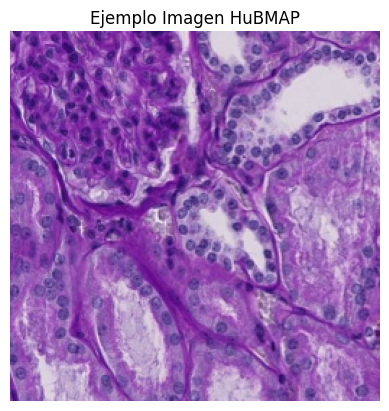

In [ ]:
sample_image_path = os.path.join(train_path, train_images_files[0])
img = cv2.imread(sample_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, img_size)

plt.imshow(img)
plt.title("Ejemplo Imagen HuBMAP")
plt.axis("off")
plt.show()

In [ ]:
# Cargar máscaras
masks = []
with open(mask_file, 'r') as f:
    for line in f:
        masks.append(json.loads(line))

## Estadísticas Descriptivas

Análisis de tile_meta.csv

In [ ]:
print(df_tiles.head())
print("\n📊 Estadísticas de columnas numéricas:")
print(df_tiles.describe())

print("\n🎯 Columnas categóricas:")
print(df_tiles.select_dtypes(include='object').nunique())

             id  source_wsi  dataset      i      j
0  0006ff2aa7cd           2        2  16896  16420
1  000e79e206b7           6        3  10240  29184
2  00168d1b7522           2        2  14848  14884
3  00176a88fdb0           7        3  14848  25088
4  0033bbc76b6b           1        1  10240  43008

📊 Estadísticas de columnas numéricas:
        source_wsi      dataset             i             j
count  7033.000000  7033.000000   7033.000000   7033.000000
mean      8.205744     2.707806  14296.542585  23227.014930
std       4.004251     0.571724   5946.054578  10644.032931
min       1.000000     1.000000   1536.000000   2560.000000
25%       6.000000     3.000000   9728.000000  15265.000000
50%       9.000000     3.000000  13824.000000  22528.000000
75%      12.000000     3.000000  18944.000000  29656.000000
max      14.000000     3.000000  30208.000000  52753.000000

🎯 Columnas categóricas:
id    7033
dtype: int64


Análisis de wsi_meta.csv

In [ ]:
print(df_wsi.head())
print("\n📊 Estadísticas WSI:")
print(df_wsi.describe())

   source_wsi  age sex race  height  weight   bmi
0           1   58   F    W   160.0    59.0  23.0
1           2   56   F    W   175.2   139.6  45.5
2           3   73   F    W   162.3    87.5  33.2
3           4   53   M    B   166.0    73.0  26.5

📊 Estadísticas WSI:
       source_wsi        age     height      weight       bmi
count    4.000000   4.000000    4.00000    4.000000   4.00000
mean     2.500000  60.000000  165.87500   89.775000  32.05000
std      1.290994   8.906926    6.68998   35.195679   9.91514
min      1.000000  53.000000  160.00000   59.000000  23.00000
25%      1.750000  55.250000  161.72500   69.500000  25.62500
50%      2.500000  57.000000  164.15000   80.250000  29.85000
75%      3.250000  61.750000  168.30000  100.525000  36.27500
max      4.000000  73.000000  175.20000  139.600000  45.50000


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

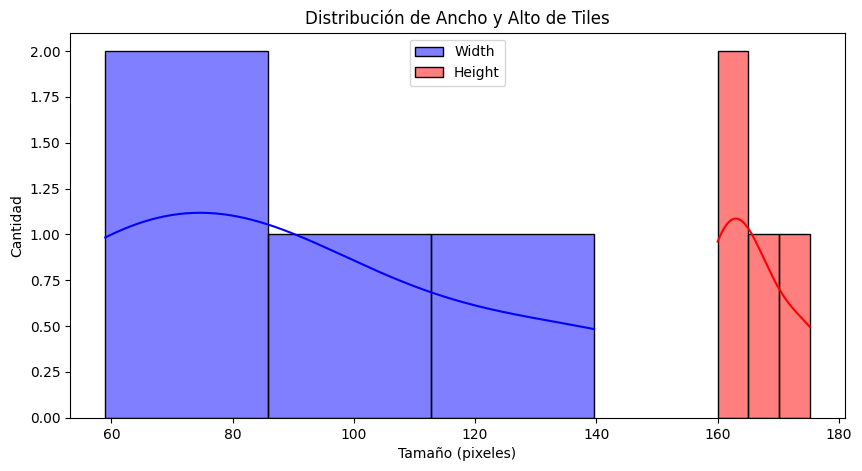

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df_wsi['weight'], kde=True, label='Width', color='blue')
sns.histplot(df_wsi['height'], kde=True, label='Height', color='red')
plt.legend()
plt.title('Distribución de Ancho y Alto de Tiles')
plt.xlabel('Tamaño (pixeles)')
plt.ylabel('Cantidad')
plt.show()

/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

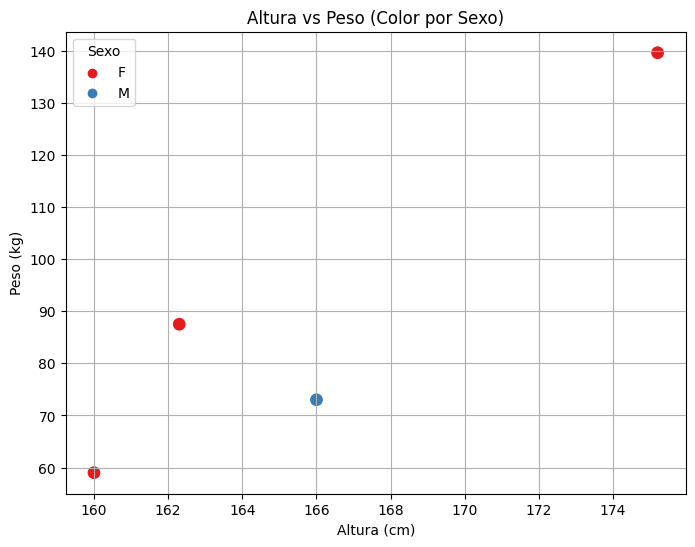

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_wsi, x='height', y='weight', hue='sex', s=100, palette='Set1')
plt.title('Altura vs Peso (Color por Sexo)')
plt.xlabel('Altura (cm)')
plt.ylabel('Peso (kg)')
plt.grid()
plt.legend(title='Sexo')
plt.show()

/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

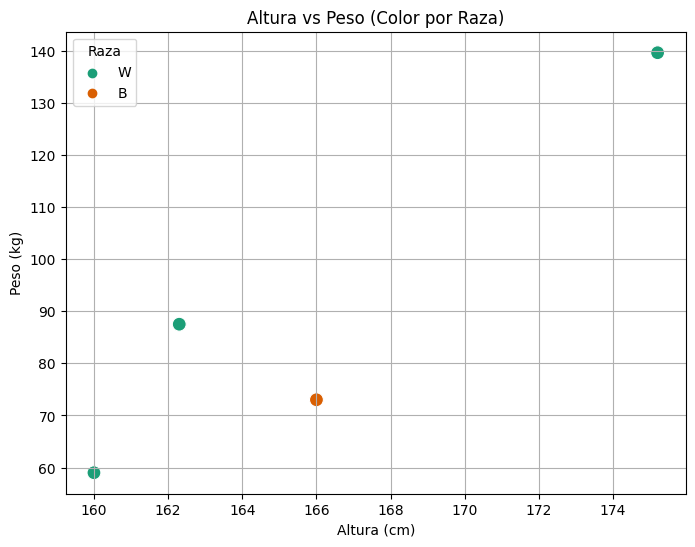

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_wsi, x='height', y='weight', hue='race', s=100, palette='Dark2')
plt.title('Altura vs Peso (Color por Raza)')
plt.xlabel('Altura (cm)')
plt.ylabel('Peso (kg)')
plt.grid()
plt.legend(title='Raza')
plt.show()

## Conclusión General
	- No se observa una correlación fuerte altura-peso en esta muestra.
	- El sexo muestra diferencias visibles en peso para una altura similar.
	- La raza no puede ser evaluada debido a la falta de balance en la muestra.
	- El BMI muestra variabilidad importante dentro del grupo femenino principalmente.

Estadísticas descriptivas del paciente:

In [ ]:
print("\n📊 Estadísticas clínicas de pacientes:")
print(df_wsi.describe())

print("\n🎯 Distribución de sexo y raza:")
print(df_wsi['sex'].value_counts())
print(df_wsi['race'].value_counts())


📊 Estadísticas clínicas de pacientes:
       source_wsi        age     height      weight       bmi
count    4.000000   4.000000    4.00000    4.000000   4.00000
mean     2.500000  60.000000  165.87500   89.775000  32.05000
std      1.290994   8.906926    6.68998   35.195679   9.91514
min      1.000000  53.000000  160.00000   59.000000  23.00000
25%      1.750000  55.250000  161.72500   69.500000  25.62500
50%      2.500000  57.000000  164.15000   80.250000  29.85000
75%      3.250000  61.750000  168.30000  100.525000  36.27500
max      4.000000  73.000000  175.20000  139.600000  45.50000

🎯 Distribución de sexo y raza:
sex
F    3
M    1
Name: count, dtype: int64
race
W    3
B    1
Name: count, dtype: int64


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

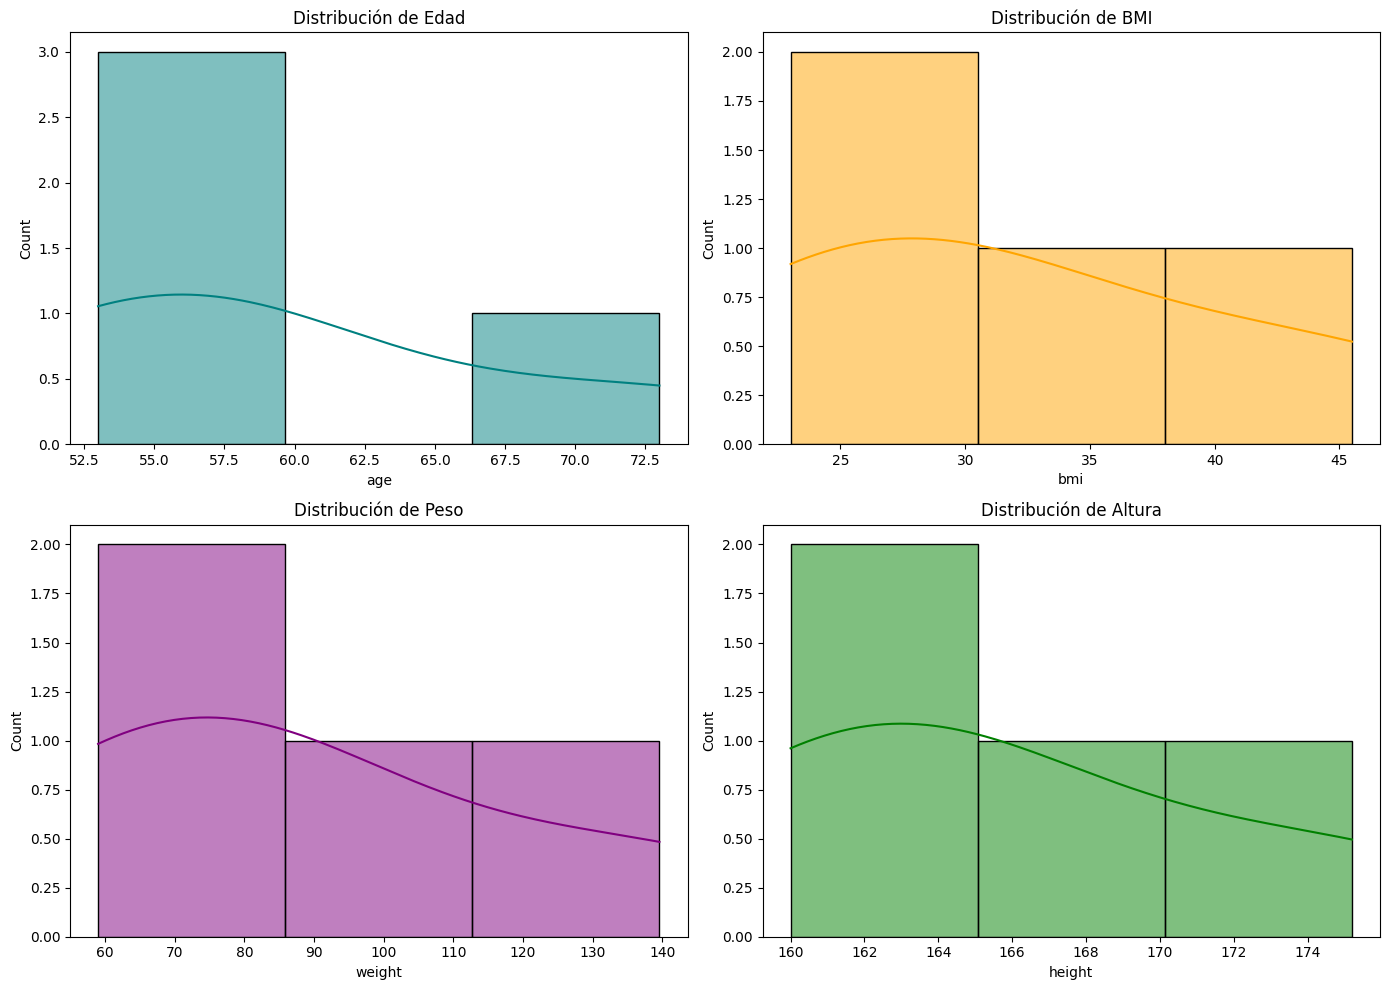

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(df_wsi['age'], kde=True, ax=axs[0,0], color='teal')
axs[0,0].set_title('Distribución de Edad')

sns.histplot(df_wsi['bmi'], kde=True, ax=axs[0,1], color='orange')
axs[0,1].set_title('Distribución de BMI')

sns.histplot(df_wsi['weight'], kde=True, ax=axs[1,0], color='purple')
axs[1,0].set_title('Distribución de Peso')

sns.histplot(df_wsi['height'], kde=True, ax=axs[1,1], color='green')
axs[1,1].set_title('Distribución de Altura')

plt.tight_layout()
plt.show()

/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

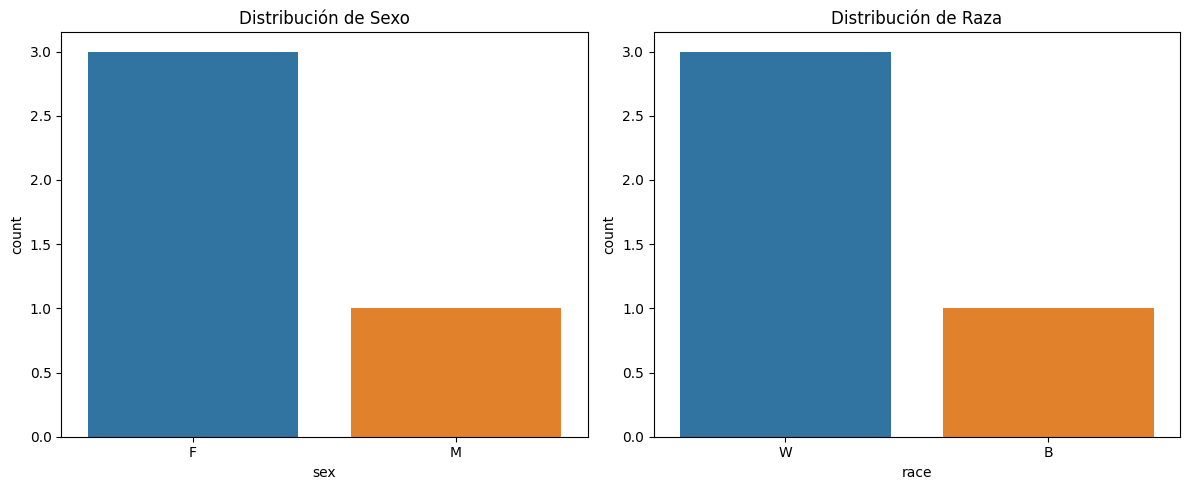

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=df_wsi, x='sex')
plt.title('Distribución de Sexo')

plt.subplot(1, 2, 2)
sns.countplot(data=df_wsi, x='race')
plt.title('Distribución de Raza')

plt.tight_layout()
plt.show()

## Conclusiones principales
	- Los pacientes en esta muestra presentaban en su mayoría un perfil de obesidad moderada (BMI > 30).
	- Existe alta dispersión en el peso, a pesar de que las alturas son relativamente similares.
	- Debido al pequeño tamaño de muestra y desbalance de clases (sexo/raza), se recomienda cautela en la generalización de estos resultados.

In [ ]:
empty_masks = []
for mask in masks:
    if len(mask['annotations']) == 0:
        empty_masks.append(mask['id'])

print(f"🚨 Número de máscaras vacías: {len(empty_masks)}")

🚨 Número de máscaras vacías: 0


Cargamos algunas imagene de entrenamiento

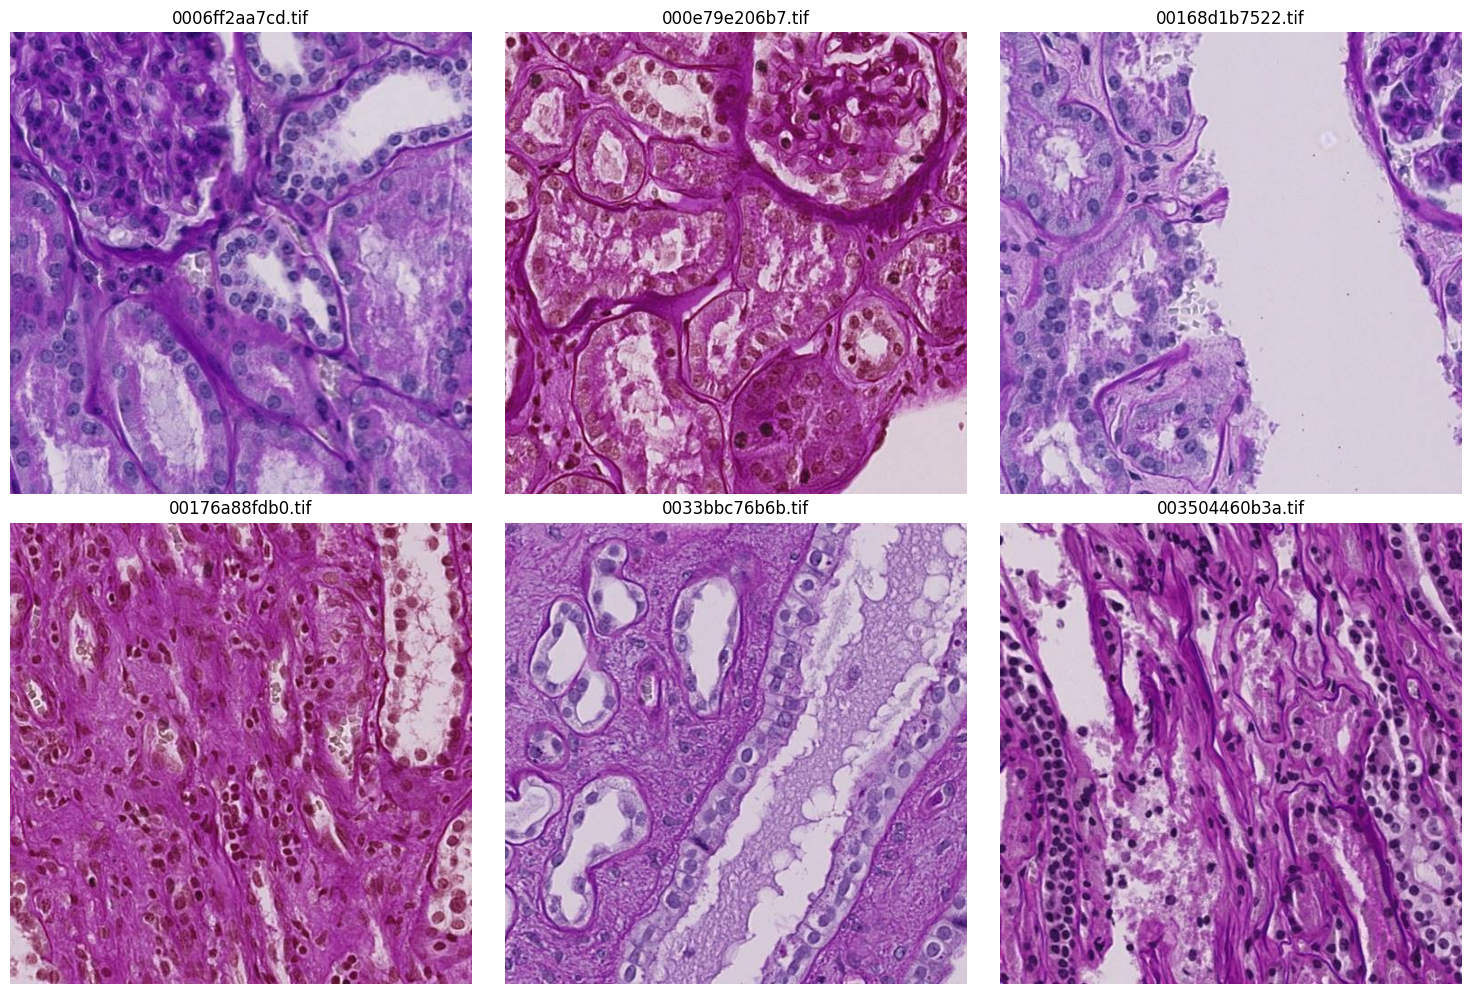

In [ ]:
# Cargar algunas imágenes de entrenamiento
train_images_files = sorted(os.listdir(train_path))

def load_image(img_name):
    img_path = os.path.join(train_path, img_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

plt.figure(figsize=(15, 10))
for idx, img_name in enumerate(train_images_files[:6]):
    img = load_image(img_name)
    plt.subplot(2, 3, idx+1)
    if img is not None:
        plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

Cargamos las mascaras

In [ ]:
import json

empty_masks = []
invalid_polygons = []

# Cargar JSONL
with open(mask_file, 'r') as f:
    masks_data = [json.loads(line) for line in f]

# Revisión de cada anotación
for entry in masks_data:
    image_id = entry.get('id', None)
    annotations = entry.get('annotations', [])
    
    if len(annotations) == 0:
        empty_masks.append(image_id)
    else:
        for ann in annotations:
            if ann['type'] == 'polygon' and len(ann['points']) < 3:
                invalid_polygons.append(image_id)

print(f"\n🚨 Número de máscaras completamente vacías: {len(empty_masks)}")
print(f"🚨 Número de máscaras con polígonos inválidos: {len(invalid_polygons)}")


🚨 Número de máscaras completamente vacías: 0
🚨 Número de máscaras con polígonos inválidos: 0


In [ ]:
import json

# Cargar todas las anotaciones
mask_file = "/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/polygons.jsonl"

masks_data = []
with open(mask_file, 'r') as f:
    for line in f:
        masks_data.append(json.loads(line))

print(f"Total de máscaras cargadas: {len(masks_data)}")

Total de máscaras cargadas: 1633


In [ ]:
annotations_per_image = [len(entry['annotations']) for entry in masks_data]

import pandas as pd
annotations_df = pd.DataFrame(annotations_per_image, columns=["n_polygons"])

print("\n📊 Estadísticas de número de polígonos por imagen:")
print(annotations_df.describe())


📊 Estadísticas de número de polígonos por imagen:
        n_polygons
count  1633.000000
mean     10.727495
std       6.582980
min       1.000000
25%       6.000000
50%      10.000000
75%      14.000000
max      53.000000


## Conclusiones:
- Distribución sesgada:
La diferencia entre el valor máximo (53) y la mediana (10) sugiere que hay algunas imágenes considerablemente más complejas que la mayoría.
_ Imágenes simples:
También existen imágenes muy simples, con solo 1 polígono.
- Impacto en segmentación:
Esta variabilidad sugiere que los modelos de segmentación pueden encontrar más difícil predecir imágenes con un número alto de polígonos, y podría ser útil usar técnicas de data augmentation específicas para estas imágenes más complejas.

In [ ]:
from shapely.geometry import Polygon

polygon_areas = []

for entry in masks_data:
    for ann in entry['annotations']:
        if ann['type'] == 'polygon' and len(ann['points']) >= 3:
            poly = Polygon(ann['points'])
            if poly.is_valid:
                polygon_areas.append(poly.area)

areas_df = pd.DataFrame(polygon_areas, columns=["polygon_area"])

print("\n📏 Estadísticas de áreas de los polígonos:")
print(areas_df.describe())


📏 Estadísticas de áreas de los polígonos:
       polygon_area
count             0
unique            0
top             NaN
freq            NaN


In [ ]:
empty_masks = sum(1 for entry in masks_data if len(entry['annotations']) == 0)
small_polygons = sum(1 for area in polygon_areas if area < 10)  # Área menor a 10 píxeles²

print(f"\n🚨 Número de máscaras vacías: {empty_masks}")
print(f"🚨 Número de polígonos extremadamente pequeños (<10 píxeles²): {small_polygons}")


🚨 Número de máscaras vacías: 0
🚨 Número de polígonos extremadamente pequeños (<10 píxeles²): 0


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


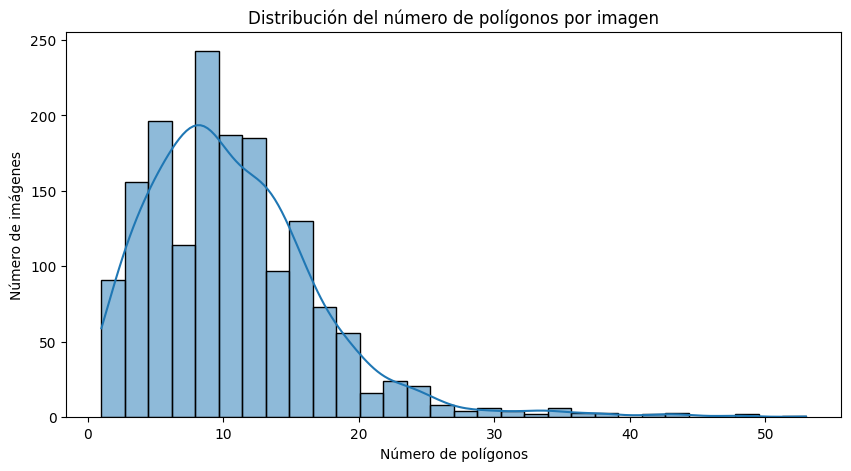

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(annotations_per_image, bins=30, kde=True)
plt.title("Distribución del número de polígonos por imagen")
plt.xlabel("Número de polígonos")
plt.ylabel("Número de imágenes")
plt.show()

La distribución del número de polígonos por imagen revela una notable heterogeneidad en la complejidad anatómica presente en el conjunto de datos, lo cual plantea un desafío adicional para el entrenamiento robusto de modelos de segmentación

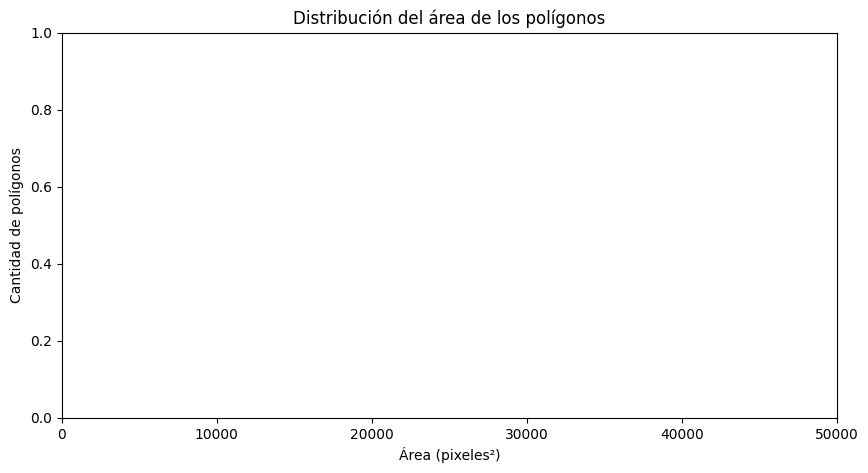

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(polygon_areas, bins=50, kde=True, color='orange')
plt.title("Distribución del área de los polígonos")
plt.xlabel("Área (pixeles²)")
plt.ylabel("Cantidad de polígonos")
plt.xlim(0, 50000)  # Limitar para evitar outliers enormes
plt.show()

In [ ]:
# Crear lista de imágenes que tienen máscaras (IDs del JSON)
dataset1_masked_images = [entry['id'] for entry in masks_data]
print(f"✅ Total de imágenes con máscaras: {len(dataset1_masked_images)}")

✅ Total de imágenes con máscaras: 1633


In [ ]:
import numpy as np
from skimage.draw import polygon

# Asumimos que cada polígono es tipo {'type': 'polygon', 'points': [(x1, y1), (x2, y2), ...]}

def display_mask(mask_json, size=(512, 512)):
    mask = np.zeros(size, dtype=np.uint8)
    
    for ann in mask_json['annotations']:
        if ann['type'] == 'polygon':
            points = ann['points']
            if len(points) >= 3:  # Un polígono necesita mínimo 3 puntos
                poly_x, poly_y = zip(*points)
                rr, cc = polygon(poly_y, poly_x, shape=size)
                mask[rr, cc] = 1  # Marcar la región como 1
    
    return mask

In [ ]:
import json

# Cargar los datos de máscaras
mask_file = "/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/polygons.jsonl"

masks_dict = {}
with open(mask_file, 'r') as f:
    for line in f:
        entry = json.loads(line)
        masks_dict[entry['id']] = entry

hacemos una carga aleatoria de las imagenes y las mostramos con las mascaras

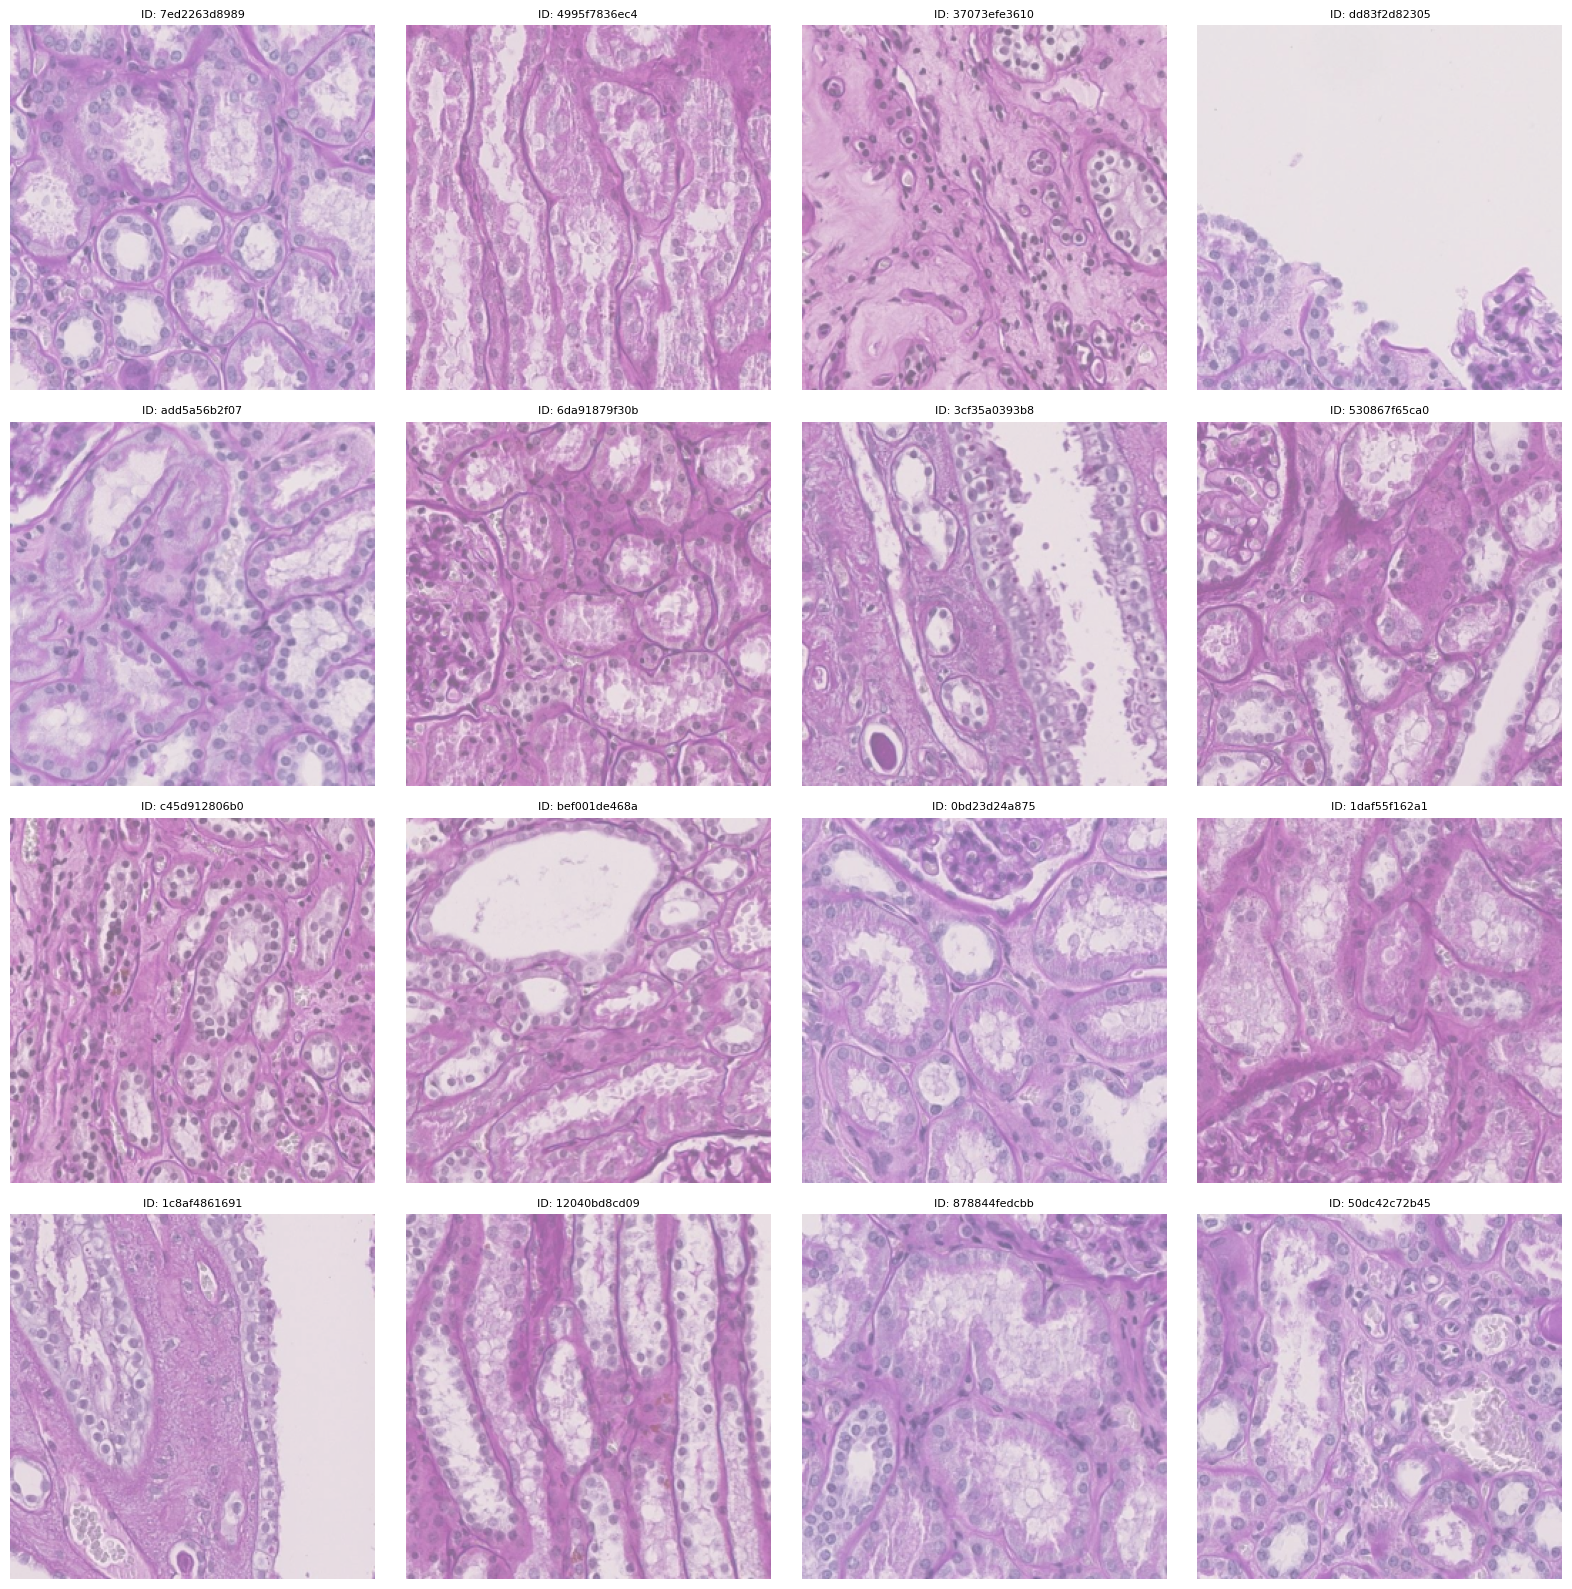

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Número de ejemplos que quieres mostrar
n_examples = 16

# Seleccionar aleatoriamente n ejemplos
sample_image_names = np.random.choice(dataset1_masked_images, n_examples, replace=False)

# Crear la figura
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()  # Aplanar para indexar fácilmente

for idx, img_name in enumerate(sample_image_names):
    # Cargar imagen
    img_path = os.path.join(train_path, f"{img_name}.tif")
    img = load_image(img_path)
    img = cv2.resize(img, img_size)
    

    # Cargar máscara
    mask = display_mask(masks_dict[img_name])
    mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)

    # Mostrar la imagen
    axes[idx].imshow(img)
    axes[idx].imshow(mask, cmap='Reds', alpha=0.4)  # Superponer la máscara
    axes[idx].axis('off')
    axes[idx].set_title(f"ID: {img_name}", fontsize=8)

plt.tight_layout()
plt.show()

Hacemos la implementacion de todos los modelos que vamos a entrenar para armar una sola validacion cruzada con las metricas de los modelos

In [ ]:
import tensorflow as tf
import numpy as np

# 1. Redimensionar imágenes
X_resized = tf.image.resize(X, (256, 256)).numpy()

# 2. Redimensionar máscaras
Y_resized = tf.image.resize(Y[..., np.newaxis], (256, 256), method='nearest').numpy()
Y_resized = Y_resized.squeeze(-1)  # (opcional)

# 3. Usar estos nuevos arrays
folds = np.array_split(np.arange(len(X_resized)), 3)

results = {}

for model_name, build_fn in models_dict.items():
    print(f"🏗 Entrenando modelo: {model_name}")
    metrics_folds = []

    for i in range(3):
        print(f"   🔹 Fold {i+1}/3")

        val_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(3) if j != i])

        X_train, Y_train = X_resized[train_idx], Y_resized[train_idx]
        X_val, Y_val = X_resized[val_idx], Y_resized[val_idx]

        model = build_fn()
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        model.fit(X_train, Y_train, epochs=3, batch_size=8, verbose=1)

        preds = model.predict(X_val)
        preds_bin = (preds >= 0.5).astype(np.uint8)

        fold_metrics = compute_all_metrics(Y_val, preds_bin, preds)
        metrics_folds.append(fold_metrics)

    results[model_name] = average_metrics(metrics_folds)

print("\n✅ Validación cruzada completada para todos los modelos.")

🏗 Entrenando modelo: U-Net
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9990 - loss: 0.0035
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 1.0000 - loss: 5.9530e-05
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9998 - loss: 0.0014
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


🏗 Entrenando modelo: V-Net
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9996 - loss: 9.8584e-04
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 575ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 1.0000 - loss: 3.2336e-05
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 602ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9999 - loss: 4.3831e-04
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 602ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


🏗 Entrenando modelo: Attention U-Net
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9603 - loss: 0.5138
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9607 - loss: 0.4155
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9605 - loss: 0.5663
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


🏗 Entrenando modelo: Mask R-CNN light
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9963 - loss: 0.0190
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 1.0000 - loss: 2.3553e-06
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 1.0000 - loss: 2.8403e-05
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


🏗 Entrenando modelo: ResUNet
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9618 - loss: 0.4992
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9999 - loss: 2.8944e-04
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9644 - loss: 0.3689
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


🏗 Entrenando modelo: PSPNet
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9599 - loss: 0.6326
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9614 - loss: 0.4099
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9691 - loss: 0.2430
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


🏗 Entrenando modelo: FCN
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9996 - loss: 0.0013
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9601 - loss: 0.6341
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9998 - loss: 0.0014
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


🏗 Entrenando modelo: Swin U-Net
   🔹 Fold 1/3
Epoch 1/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9600 - loss: 0.6343
Epoch 2/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
136/136 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 2/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9601 - loss: 0.6352
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


   🔹 Fold 3/3
Epoch 1/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9748 - loss: 0.1827
Epoch 2/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
Epoch 3/3
137/137 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


/opt/anaconda3/envs/cams_venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



✅ Validación cruzada completada para todos los modelos.


/var/folders/wz/grp_08gn7mnfdscpgzzwdw6w0000gn/T/ipykernel_27118/735559615.py:54: RuntimeWarning: invalid value encountered in scalar divide
  balanced_acc = 0.5 * (tp / (tp + fn) + tn / (tn + fp))


## U-Net

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input

def unet_model(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(shape=input_shape)
    # Encoder (contracción)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    # Bottleneck
    b = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    b = Conv2D(1024, 3, activation='relu', padding='same')(b)
    # Decoder (expansión) con skip connections
    u4 = UpSampling2D(size=(2, 2))(b)
    m4 = Concatenate()([u4, c4])               # concatenar con c4 del encoder
    c5 = Conv2D(512, 3, activation='relu', padding='same')(m4)
    c5 = Conv2D(512, 3, activation='relu', padding='same')(c5)
    u3 = UpSampling2D(size=(2, 2))(c5)
    m3 = Concatenate()([u3, c3])               # concatenar con c3
    c6 = Conv2D(256, 3, activation='relu', padding='same')(m3)
    c6 = Conv2D(256, 3, activation='relu', padding='same')(c6)
    u2 = UpSampling2D(size=(2, 2))(c6)
    m2 = Concatenate()([u2, c2])               # concatenar con c2
    c7 = Conv2D(128, 3, activation='relu', padding='same')(m2)
    c7 = Conv2D(128, 3, activation='relu', padding='same')(c7)
    u1 = UpSampling2D(size=(2, 2))(c7)
    m1 = Concatenate()([u1, c1])               # concatenar con c1
    c8 = Conv2D(64, 3, activation='relu', padding='same')(m1)
    c8 = Conv2D(64, 3, activation='relu', padding='same')(c8)
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(c8)  # máscara segmentación
    model = tf.keras.Model(inputs, outputs)
    return model

model_unet = unet_model()
model_unet.summary()

Model: "functional_91"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_114     │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_922 (Conv2D) │ (None, 256, 256,  │      1,792 │ input_layer_114[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_923 (Conv2D) │ (None, 256, 256,  │     36,928 │ conv2d_922[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_187   │ (None, 128, 128,  │          0 │ conv2d_923[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_924 (Conv2D) │ (None, 128, 128,  │     73,856 │ max_pooling2d_18… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_925 (Conv2D) │ (None, 128, 128,  │    147,584 │ conv2d_924[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_188   │ (None, 64, 64,    │          0 │ conv2d_925[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_926 (Conv2D) │ (None, 64, 64,    │    295,168 │ max_pooling2d_18… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_927 (Conv2D) │ (None, 64, 64,    │    590,080 │ conv2d_926[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_189   │ (None, 32, 32,    │          0 │ conv2d_927[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_928 (Conv2D) │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_18… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_929 (Conv2D) │ (None, 32, 32,    │  2,359,808 │ conv2d_928[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_190   │ (None, 16, 16,    │          0 │ conv2d_929[0][0]  │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_930 (Conv2D) │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_19… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_931 (Conv2D) │ (None, 16, 16,    │  9,438,208 │ conv2d_930[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_218   │ (None, 32, 32,    │          0 │ conv2d_931[0][0]  │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_183     │ (None, 32, 32,    │          0 │ up_sampling2d_21

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

## V-Net

In [ ]:
# ------------------------------------------
# IMPORTS
# ------------------------------------------
import os
import cv2
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Add, Activation
from tensorflow.keras.models import Model

# ------------------------------------------
# PATHS
# ------------------------------------------
train_path = '/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/train'
mask_file = '/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/polygons.jsonl'

# ------------------------------------------
# FUNCIONES AUXILIARES
# ------------------------------------------
def load_polygons(mask_file):
    polygons = []
    with open(mask_file, 'r') as f:
        for line in f:
            polygons.append(json.loads(line))
    return pd.DataFrame(polygons)

def create_mask_from_polygons(annotation_row, image_shape):
    mask = np.zeros(image_shape, dtype=np.uint8)
    for annotation in annotation_row['annotations']:
        for polygon in annotation['coordinates']:
            points = np.array(polygon, dtype=np.int32)
            cv2.fillPoly(mask, [points], 1)
    return mask

def residual_block(x, filters):
    shortcut = Conv2D(filters, (1, 1), padding="same")(x)
    x = Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = Add()([shortcut, x])
    x = Activation("relu")(x)
    return x

def build_fn(input_shape=(256,256,3), num_classes=1):
    inputs = Input(shape=input_shape)

    c1 = residual_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    b = residual_block(p2, 256)

    u2 = UpSampling2D((2, 2))(b)
    x2 = Concatenate()([u2, c2])
    d2 = residual_block(x2, 128)

    u1 = UpSampling2D((2, 2))(d2)
    x1 = Concatenate()([u1, c1])
    d1 = residual_block(x1, 64)

    outputs = Conv2D(num_classes, (1,1), activation='sigmoid', padding='same')(d1)

    model = Model(inputs, outputs)
    return model

# ------------------------------------------
# CARGA DE DATOS
# ------------------------------------------
print("📥 Cargando polígonos...")
polygons_df = load_polygons(mask_file)

# Filtrar solo imágenes existentes
train_images_files = os.listdir(train_path)
train_image_ids = set([os.path.splitext(f)[0] for f in train_images_files])
polygons_df = polygons_df[polygons_df['id'].isin(train_image_ids)].reset_index(drop=True)

print(f"✅ Imágenes disponibles: {len(polygons_df)}")

# Crear arrays X y Y
X = []
Y = []
img_size = (256, 256)

print("⚙️ Procesando imágenes y máscaras...")

for idx in tqdm(range(len(polygons_df))):
    row = polygons_df.iloc[idx]
    image_id = row['id']
    annotations = row

    image_path = os.path.join(train_path, f"{image_id}.tiff")

    if not os.path.exists(image_path):
        continue

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0

    mask = create_mask_from_polygons(annotations, tuple(row['dimensions'])[::-1])
    mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)

    X.append(img)
    Y.append(mask)

# Convertir listas a np.array
X = np.array(X)
Y = np.array(Y)

print('✅ Shapes:')
print('X:', X.shape)
print('Y:', Y.shape)

# ------------------------------------------
# DIVISIÓN TRAIN / VAL
# ------------------------------------------
print("✂️ Dividiendo en train y val sets...")

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print('Train:', X_train.shape, Y_train.shape)
print('Val:', X_val.shape, Y_val.shape)

# ------------------------------------------
# ENTRENAMIENTO V-NET
# ------------------------------------------
print("🚀 Entrenando modelo...")

model = build_fn(input_shape=(256,256,3), num_classes=1)
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=5,  # Puedes cambiar a 20-50 en entrenamiento real
    batch_size=8,
    verbose=1
)

# ------------------------------------------
# CURVA DE ENTRENAMIENTO
# ------------------------------------------
print("📈 Plotting training curves...")

plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid()
plt.legend()
plt.show()

📥 Cargando polígonos...
✅ Imágenes disponibles: 1633
⚙️ Procesando imágenes y máscaras...


100%|██████████| 1633/1633 [00:00<00:00, 18706.01it/s]

✅ Shapes:
X: (0,)
Y: (0,)
✂️ Dividiendo en train y val sets...


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Add, Concatenate
import tensorflow as tf

def residual_block(x, filters):
    shortcut = Conv2D(filters, (1, 1), padding="same")(x)
    x = Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = Add()([shortcut, x])
    x = tf.keras.layers.Activation("relu")(x)
    return x

def vnet2d_model(input_shape=(512, 512, 3), num_classes=1):
    inputs = Input(input_shape)
    # Encoder
    c1 = residual_block(inputs, 64)
    p1 = MaxPooling2D((2,2))(c1)
    c2 = residual_block(p1, 128)
    p2 = MaxPooling2D((2,2))(c2)
    # Bottleneck
    bn = residual_block(p2, 256)
    # Decoder
    u2 = UpSampling2D((2,2))(bn)
    m2 = Concatenate()([u2, c2])   # ❗ OJO aquí usamos Concatenate, no Add
    d2 = residual_block(m2, 128)
    u1 = UpSampling2D((2,2))(d2)
    m1 = Concatenate()([u1, c1])
    d1 = residual_block(m1, 64)
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(d1)
    return tf.keras.Model(inputs, outputs)

# Crear el modelo
model_vnet2d = vnet2d_model()
model_vnet2d.summary()

Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_85      │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_700 (Conv2D) │ (None, 512, 512,  │      1,792 │ input_layer_85[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_699 (Conv2D) │ (None, 512, 512,  │        256 │ input_layer_85[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_701 (Conv2D) │ (None, 512, 512,  │     36,928 │ conv2d_700[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_61 (Add)        │ (None, 512, 512,  │          0 │ conv2d_699[0][0], │
│                     │ 64)               │            │ conv2d_701[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_80       │ (None, 512, 512,  │          0 │ add_61[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_130   │ (None, 256, 256,  │          0 │ activation_80[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_703 (Conv2D) │ (None, 256, 256,  │     73,856 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_702 (Conv2D) │ (None, 256, 256,  │      8,320 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_704 (Conv2D) │ (None, 256, 256,  │    147,584 │ conv2d_703[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_62 (Add)        │ (None, 256, 256,  │          0 │ conv2d_702[0][0], │
│                     │ 128)              │            │ conv2d_704[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_81       │ (None, 256, 256,  │          0 │ add_62[0][0]      │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_131   │ (None, 128, 128,  │          0 │ activation_81[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_706 (Conv2D) │ (None, 128, 128,  │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_705 (Conv2D) │ (None, 128, 128,  │     33,024 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_707 (Conv2D) │ (None, 128, 128,  │    590,080 │ conv2d_706[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_63 (Add)        │ (None, 128, 128,  │          0 │ conv2d_705[0][0]

 Total params: 1,986,369 (7.58 MB)

 Trainable params: 1,986,369 (7.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import json
from tqdm import tqdm

# Paths
train_path = '/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/train'
mask_file = '/Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/polygons.jsonl'

# Funciones auxiliares
def load_polygons(mask_file):
    polygons = []
    with open(mask_file, 'r') as f:
        for line in f:
            polygons.append(json.loads(line))
    return pd.DataFrame(polygons)

def create_mask_from_polygons(annotation_row, image_shape):
    mask = np.zeros(image_shape, dtype=np.uint8)
    for annotation in annotation_row['annotations']:
        for polygon in annotation['coordinates']:
            points = np.array(polygon, dtype=np.int32)
            cv2.fillPoly(mask, [points], 1)
    return mask

# Cargar metadata
print("📥 Cargando metadata...")
polygons_df = load_polygons(mask_file)

# Filtrar solo imágenes existentes
train_images_files = os.listdir(train_path)
train_image_ids = set([os.path.splitext(f)[0] for f in train_images_files])
polygons_df = polygons_df[polygons_df['id'].isin(train_image_ids)].reset_index(drop=True)

print(f"✅ Imágenes disponibles en carpeta: {len(polygons_df)}")

# Preparar X y Y
X = []
Y = []
img_size = (256, 256)

print("⚙️ Procesando imágenes y máscaras válidas...")

for idx in tqdm(range(len(polygons_df))):
    row = polygons_df.iloc[idx]
    image_id = row['id']
    annotations = row

    image_path = os.path.join(train_path, f"{image_id}.tiff")

    if not os.path.exists(image_path):
        print(f"❌ Imagen no encontrada: {image_path}")
        continue

    # Leer imagen
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ No se pudo leer imagen: {image_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalizar

    # Crear máscara
    orig_shape = tuple(row['dimensions'])
    mask = create_mask_from_polygons(annotations, orig_shape[::-1])

    if mask.sum() == 0:
        print(f"⚠️ Máscara vacía para: {image_id}")
        continue

    mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)

    # Agregar solo imágenes y máscaras válidas
    X.append(img)
    Y.append(mask)

# Convertir a arrays
X = np.array(X)
Y = np.array(Y)

print('✅ Dataset final:')
print('X shape:', X.shape)
print('Y shape:', Y.shape)

📥 Cargando metadata...
✅ Imágenes disponibles en carpeta: 1633
⚙️ Procesando imágenes y máscaras válidas...


100%|██████████| 1633/1633 [00:00<00:00, 17803.61it/s]

❌ Imagen no encontrada: /Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/train/0006ff2aa7cd.tiff
❌ Imagen no encontrada: /Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/train/00168d1b7522.tiff
❌ Imagen no encontrada: /Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/train/0033bbc76b6b.tiff
❌ Imagen no encontrada: /Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/train/003504460b3a.tiff
❌ Imagen no encontrada: /Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/train/004daf1cbe75.tiff
❌ Imagen no encontrada: /Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/train/005715f0a313.tiff
❌ Imagen no encontrada: /Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/train/00654cc08aac.tiff
❌ Imagen no encontrada: /Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/train/00656c6f2690.tiff
❌ Imagen no encontrada: /Users/carlosmeza/Downloads/hubmap-hacking-the-human-vasculature/train/0

## SegNet

In [ ]:
def segnet_model(input_shape=(256,256,3), num_classes=1):
    inputs = Input(shape=input_shape)
    # Encoder (ejemplo con 2 capas conv seguidas de pooling)
    x = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    p1 = MaxPooling2D((2,2))(x)   # en SegNet real, guardar indices de max pooling
    x = Conv2D(128, 3, activation='relu', padding='same')(p1)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    p2 = MaxPooling2D((2,2))(x)   # guardar indices
    # Decoder (upsampling usando índices guardados en lugar de aprender)
    x = UpSampling2D((2,2))(p2)   # en SegNet, hacer un upsampling conforme a indices de p2
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)    # usar indices de p1
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs)